## FBCCA and Extended FBCCA for SSVEP signals classification

In [2]:
# Imports:
from tqdm import tqdm

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as sio

import re

from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

from scipy.signal import butter, lfilter, periodogram

import os


## Description of the task:

To implement the FBCCA method on python, follow these steps:

- Define the parameters for the FBCCA method, such as the number of harmonics (Nh), the weight vector (w), the number of sub-bands (N), and the filter bank design (M1, M2, or M3): (M1: sub-bands with equally spaced bandwidths; M2: sub-bands corresponding to individual harmonic frequency bands; M3: sub-bands covering multiple harmonic frequency bands.

- Define the reference signals for each stimulation frequency using function 5 (generate_ref_signal). The reference signals should have a shape of (n_samples, Nh * 2), where n_samples is the number of samples in your signal window.

- Define a function to perform CCA between two multi-dimensional variables. Use the CCA module from sklearn.cross_decomposition.

- Define a function to perform filter bank analysis on your SSVEP signals using a zero-phase Chebyshev Type I IIR filter. You can use the filtfilt() function from scipy.signal to apply the filter. The filter bank analysis should output a set of sub-band signals, each with a shape of (n_samples, n_channels), where n_channels is the number of channels in your signals.

- For each sub-band signal, apply the CCA function to calculate the correlation vector between the sub-band signal and the reference signals for each stimulation frequency using equation (5). The correlation vector should have a shape of (1, Nh * 2).

- For each stimulation frequency, calculate the feature vector by using a weighted sum of squares of the correlation values corresponding to all sub-band components using equation (6). The feature vector should have a shape of (1, N).

- Compare the feature vector with a threshold value to determine the target frequency. The threshold value can be optimized by a grid search method. If the feature vector exceeds the threshold value, then the target frequency is the frequency corresponding to the reference signal. If not, then the target frequency is unknown.
Source: "Filter bank canonical correlation analysis for implementing a high-speed" by Xiaogang Chen, et al. 2015
SSVEP-based brain-computer interface
https://pubmed.ncbi.nlm.nih.gov/26035476/


> Obs:

The bandwidth of the stimulation frequencies (8-15.8Hz) was 8Hz in this study

Therefore, the frequency
range within [8Hz 88Hz] (i.e., 10 times of the bandwidth of the stimulation frequencies)

In [3]:
"""Utility functions"""


def get_FFT(x):
    fft = abs(np.fft.fft(x))
    # calculate the frequencies
    freqs = np.fft.fftfreq(len(x)) * 250
    return fft, freqs


# Function 5: generate_ref_signal
# Input: Freq_phase_path, SSVEP frecuencies (targets), number of samples, number of harmonics, sampling frequency
# Output: reference signal
def generate_ref_signal(Freq_phase_path: str, freqs: list, N: int, n_harmonics: int, fs: int) -> np.ndarray:
    data = sio.loadmat(Freq_phase_path)
    index_freqs = data['freqs'].round(1).reshape(-1).tolist()
    phases = data['phases'].reshape(-1)  # phases

    # Reference signal
    ref_signal = np.zeros((n_harmonics * 2, len(freqs), N))
    # For each frequency
    f = 0
    for frequency in freqs:
        phase = phases[index_freqs.index(round(frequency, 1))]

        # For each harmonic
        for i in range(0, n_harmonics):
            # Sinusoid
            ref_signal[i, f, :] = np.sin(
                2 * np.pi * frequency * (i + 1) * np.arange(N) / fs + phase)
            # Cosinusoid
            ref_signal[i + 1, f, :] = np.cos(2 * np.pi *
                                             frequency * (i + 1) * np.arange(N) / fs + phase)

        f += 1

    return ref_signal

# Function 1: filter_bank_analysis
# Input: signal, sampling frequency, number of sub-bands, filter bank design
# Output: sub-band signals


def filter_bank_analysis(in_signal, fs, n_subbands, filter_bank_design, low_freq, bandwith=8):
    # Number of channels
    n_channels = in_signal.shape[0]
    # Number of samples
    n_samples = in_signal.shape[1]

    gpass, gstop, Rp = 3, 40, 0.5
    highcut_pass, highcut_stop = 80, 90

    # Filter bank design
    if filter_bank_design == 'M1':  # N_subbands of the same length
        # Sub-band signals
        subband_signals = np.zeros((n_subbands, n_channels, n_samples))
        # For each sub-band
        for i in range(0, n_subbands):

            passband = low_freq + (i * 8)
            highcut_pass = passband + bandwith

            stopband = passband - (fs / 50)
            highcut_stop = highcut_pass + (fs / 50)

            Wp = [passband / (fs/2), highcut_pass / (fs/2)]
            Ws = [stopband / (fs/2), highcut_stop / (fs/2)]

            N, Wn = signal.cheb1ord(Wp, Ws, gpass, gstop)
            # Sub-band filter
            b, a = signal.cheby1(N, Rp, Wn, 'bandpass')
            # Filtered signal
            subband_signals[i, :, :] = signal.filtfilt(b, a, in_signal)

    elif filter_bank_design == 'M2':
        raise NotImplementedError()

    elif filter_bank_design == 'M3':
        raise NotImplementedError()

    else:
        raise NotImplementedError("Design not supported")

    return subband_signals

# Function 2: cca
# Input: signal 1, signal 2
# Output: correlation vector


def cca(signal1, signal2):
    # Canonical correlation analysis
    cca = CCA(1)

    # Fit the model with signal 1 and signal 2
    cca.fit(signal1.T, signal2.T)

    # Correlation vector
    X_c, Y_c = cca.transform(signal1.T, signal2.T)

    return X_c, Y_c


# Function 3: feature_extraction
# Input: sub-band signals, reference signals, weight vector
# Output: feature vector
def feature_extraction(subband_signals, ref_signals):
    # Number of sub-band signals
    n_subbands = subband_signals.shape[0]
    # Feature vector
    feature_vector = np.zeros(ref_signals.shape[1])
    # Class predicted
    fb_coefs = [pow(i, -1.25) + 0.25 for i in range(1, n_subbands + 1)]
    result = 0
    # For each sub-band signal
    for sub in range(n_subbands):
        for freq in range(ref_signals.shape[1]):
            # Correlation vector
            X_c, Y_c = cca(subband_signals[sub, :, :], ref_signals[:, freq, :])
            # Pearson correlation coefficient
            correl = np.corrcoef(X_c[:, 0], Y_c[:, 0])
            feature_vector[freq] = correl[0, 1]

        result += (fb_coefs[sub] * (feature_vector ** 2))
        predicted = np.argmax(result)

    return predicted


# Function 4: fbcca
# Input: signal, sampling frequency, number of sub-bands, filter bank design, weight vector, reference signals, lowest frequency
# Output: target frequency
def fbcca(in_signal, fs, n_subbands, filter_bank_design, ref_signals, lowest_freq):
    # Perform filter bank analysis
    subband_signals = filter_bank_analysis(
        in_signal, fs, n_subbands, filter_bank_design, lowest_freq)
    # Target frequency
    predicted = feature_extraction(subband_signals, ref_signals)
    return predicted


# Function 3: feature_extraction
# Input: sub-band signals, reference signals, weight vector
# Output: feature vector
def feature_extraction_ECCA(subband_signals, ref_signals, template_signal):
    # Number of sub-band signals
    n_subbands = subband_signals.shape[0]
    # Feature vector
    feature_vector = np.zeros(ref_signals.shape[1])
    fb_coefs = [pow(i, -1.25) + 0.25 for i in range(1, n_subbands + 1)]
    result = 0

    # For each sub-band signal
    for sub in range(n_subbands):
        for freq in range(ref_signals.shape[1]):

            # ************* 2 CCAs *************
            # 1: signal vs reference
            # Correlation vector
            X_c1, Y_c1 = cca(
                subband_signals[sub, :, :], ref_signals[:, freq, :])
            # Pearson correlation coefficient

            # 2: signal vs eeg template
            # Correlation vector
            X_c2, Y_c2 = cca(
                subband_signals[sub, :, :], template_signal[freq, :, :])

            # Pearson correlation coefficients
            rho1 = np.corrcoef(X_c1[:, 0], Y_c1[:, 0])[0, 1]
            rho2 = np.corrcoef(X_c2[:, 0], Y_c1[:, 0])[0, 1]
            rho3 = np.corrcoef(X_c1[:, 0], Y_c2[:, 0])[0, 1]
            rho4 = np.corrcoef(X_c1[:, 0], Y_c2[:, 0])[0, 1]

            correl = (np.sign(rho1)*(rho1**2) +
                      np.sign(rho2)*(rho2**2) +
                      np.sign(rho3)*(rho3**2) +
                      np.sign(rho4)*(rho4**2))

            feature_vector[freq] = correl

        result += (fb_coefs[sub] * (feature_vector ** 2))
        predicted = np.argmax(result)

    return predicted


# Function 6: Combined CCA (ref signals + templates)
# Input: signal, sampling frequency, number of sub-bands, filter bank design, reference signals, lowest frequency, upmost frequency
# Output: target frequency
def combined_cca(in_signal, template_signal, fs, n_subbands, filter_bank_design, ref_signals, lowest_freq):
    # Perform filter bank analysis
    subband_signals = filter_bank_analysis(
        in_signal, fs, n_subbands, filter_bank_design, lowest_freq)
    # Target frequency
    predicted = feature_extraction_ECCA(
        subband_signals, ref_signals, template_signal)
    return predicted



The frequency and phase values are used to generate the SSVEP stimuli. The stimuli are generated by the following equation:

$$
x(t) = sin(2\pi f t + \phi)
$$

where $f$ is the frequency and $\phi$ is the phase value.

In [8]:
# SSVEP target frequencies
frequencies = [8, 9, 10, 11]
# Number of samples
N = 1024
# Sampling frequency
fs = 250
# Number of harmonics
n_harmonics = 3
# Number of sub-bands
n_subbands = 8
# Filter bank design
filter_bank_design = 'M1'
# Reference signals
ref_signals = generate_ref_signal(
    'data/raw/Freq_Phase.mat', frequencies, N, n_harmonics, fs)


In [74]:
def get_acc_of_subject_ECCA(subject, path, template_path, target, labels, synt_ratio=0.5):

    synth_template = np.zeros((4, 6, 3, 1024))
    # leave 1 window to perform testing (load 6 out of 7 windows to create the template)
    real_template = np.zeros((4, 6, 3, 1024))

    # Get the synthetic data for the subject (results of StarGan)
    for label in labels:
        synth_template[label] = np.load(f"{template_path}ref_0{label}_b.npy")[
            :6, :, :]  # (8, 3, 1024) 8 is batch_size
        # Get the real data for the subject
        for i in range(6):
            real_template[label, i, :, :] = np.load(
                path + f"{label}/S{subject}_{i}.npy")

    # get the average of the concatenated array
    if synt_ratio == 0:
        template = np.mean(real_template, axis=1)
    elif synt_ratio == 1:
        template = np.mean(synth_template, axis=1)
    else:
        template = np.mean(
            np.concatenate((
                real_template[:,:(int((1 - synt_ratio) * synth_template.shape[0]))],
                synth_template[:,:int(synt_ratio) *
                                   synth_template.shape[0]]
            ), axis = 1), axis=1)

    in_signal = np.load(path + f"{target}/S{subject}_6.npy")
    # print(f"Shape of templates: {real_template.shape}, {synth_template.shape}, {template.shape}")
    target_frequency = combined_cca(
        in_signal, template, fs, n_subbands, filter_bank_design, ref_signals, 8)

    acc = accuracy_score([target], [target_frequency])

    return acc

def get_acc_of_subject(subject, path, label, w_size=4):

    # get all .npy files of the subject
    files = os.listdir(path)

    predictions = []

    for file in files:
        if re.match(f"^{subject}_.\.npy$", file) and file.endswith(".npy"):
            in_signal = np.load(path + file)
            target_frequency = fbcca(
                in_signal, fs, n_subbands, filter_bank_design, ref_signals, 8)
            predictions.append(target_frequency)

    targets = np.ones(len(predictions)) * label
    # calculate the accuracy
    acc = accuracy_score(targets, predictions)

    return acc


In [75]:
template_path = "expr/results/vanilla/"
path = "data/staged/"
labels = [0, 1, 2, 3]

bins = 4
accs_ratio = np.zeros(bins + 1)

for k in range(bins + 1):

    accs = np.zeros(36)

    for label in tqdm(labels):

        path = f"data/staged/"

        for i in range(1, 36):
            acc = get_acc_of_subject_ECCA(
                i, path, template_path, label, labels, synt_ratio=(1/bins) * k)
            accs[i - 1] += acc * 1 / len(labels)

    accs_ratio[k] = np.mean(accs)

print(accs_ratio)

100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

[0.85416667 0.82638889 0.83333333 0.82638889 0.83333333]


In [17]:
labels = [0, 1, 2, 3]

window_size = 4

accs = np.zeros(36)

for label in tqdm(labels):

    path = f"data/staged/{label}/"

    for i in range(1, 36):
        acc = get_acc_of_subject(f"S{i}", path, label, window_size)
        accs[i - 1] += acc * 1 / len(labels)


print(accs)


100%|██████████| 4/4 [00:24<00:00,  6.17s/it]

[1.         0.92857143 1.         0.89285714 0.96428571 1.
 0.92857143 0.92857143 0.92857143 0.92857143 0.67857143 0.89285714
 0.71428571 0.92857143 1.         0.96428571 0.96428571 0.82142857
 0.67857143 0.92857143 0.96428571 0.92857143 0.85714286 1.
 0.92857143 0.92857143 1.         1.         0.78571429 0.92857143
 1.         1.         0.5        0.96428571 0.92857143 0.        ]


In [ ]:
window_sizes = [1, 1.5, 2, 2.5, 3, 3.5, 4]


path = "data/staged/0/"

label = 0

for window_size in window_sizes:
    accs = []

    for i in range(1, 36):

        acc = get_acc_of_subject(f"S{i}", path, label, 4)
        accs.append(acc)

    print(f"Accuracy for window size {4}: {np.mean(accs)}")


In [22]:
# Check results
path = "expr/results/vanilla/"

labels = [0, 1, 2, 3]

for label in labels:
    data = np.load(f"{path}ref_0{label}_b.npy")

    y_pred = []

    for batch in range(data.shape[0]):
        target_frequency = fbcca(
            data[batch], fs, n_subbands, filter_bank_design, ref_signals, 8)
        y_pred.append(target_frequency)

    targets = np.ones(len(y_pred)) * label

    # calculate the accuracy
    acc = accuracy_score(targets, y_pred)
    print(f"Accuracy for label {label}: {acc}")


Accuracy for label 0: 0.5
Accuracy for label 1: 0.0
Accuracy for label 2: 1.0
Accuracy for label 3: 1.0


an improvement of 0.014761904761111277


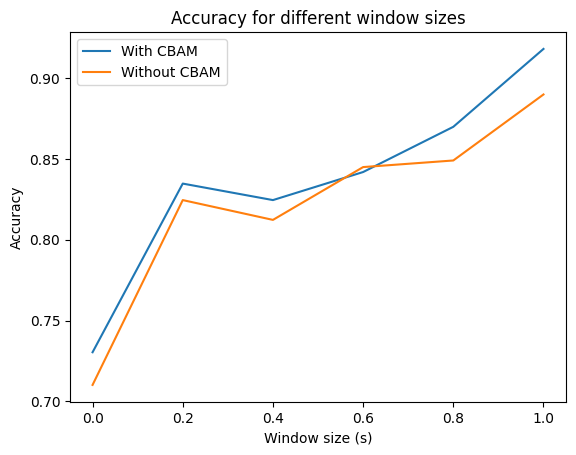

In [9]:
"""
Accuracy for window size 1: 0.7102040816326531, 0.7304081632605301 (with CBAM)
Accuracy for window size 1.5: 0.7591836734693878, 0.7561224489795918 (with CBAM)
Accuracy for window size 2: 0.8244897959183675,  0.834693877551021 (with CBAM)
Accuracy for window size 2.5: 0.8122448979591838, 0.82448979591838 (with CBAM)
Accuracy for window size 3: 0.8448979591836734, 0.8418367346938775 (with CBAM)
Accuracy for window size 3.5: 0.8489795918367347, 0.869795918367347 (with CBAM)
Accuracy for window size 4: 0.8897959183673471, 0.917959183673471 (with CBAM)
"""

# plot the results of the comment above
accs = [0.7102040816326531,  0.8244897959183675, 0.8122448979591838,
        0.8448979591836734, 0.8489795918367347, 0.8897959183673471]
accs_cbam = [0.7304081632605301, 0.834693877551021, 0.82448979591838,
             0.8418367346938775, 0.869795918367347, 0.917959183673471]

# window sizes
window_sizes = [0, 0.2, 0.4, 0.6, 0.8, 1]

# use barplots
plt.plot(window_sizes, accs_cbam, label="With CBAM")
plt.plot(window_sizes, accs, label="Without CBAM")
plt.legend()
plt.xlabel("Window size (s)")
plt.ylabel("Accuracy")
plt.title("Accuracy for different window sizes")

print(f"an improvement of {np.mean(accs_cbam) - np.mean(accs)}")


(32, 3, 1024)


(0.0, 20.0)

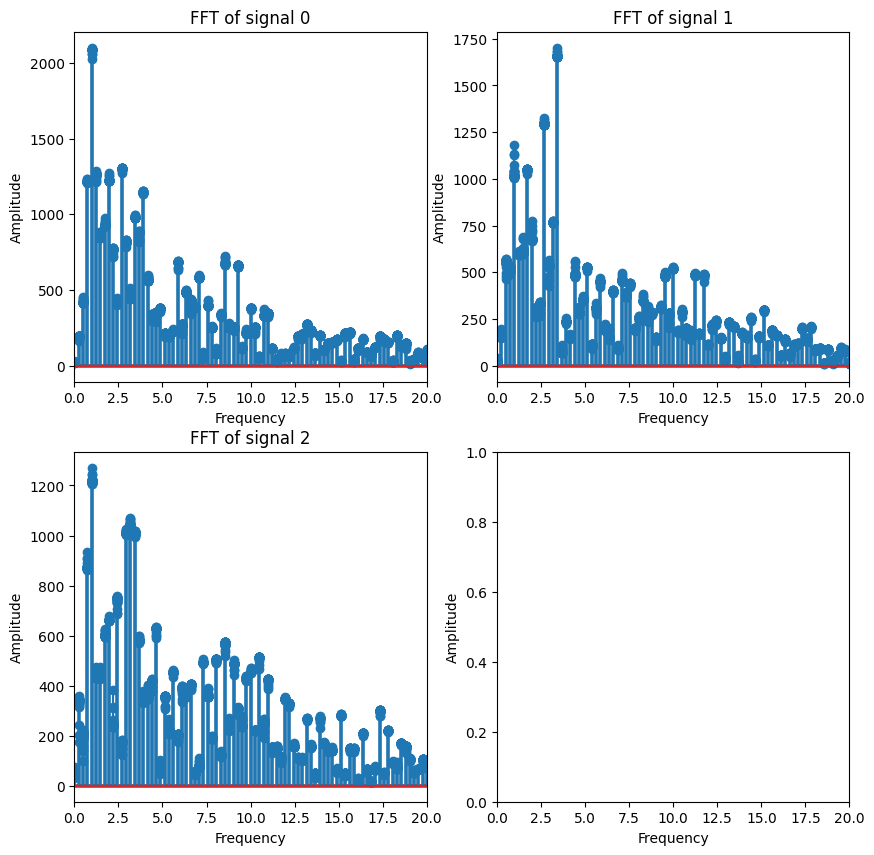

In [6]:
data = "expr/results/vanilla/ref_01_b.npy"

sample = (np.load(data))
print(sample.shape)
x = sample
ss = 2

fig, axs = plt.subplots(ss, ss, figsize=(10, 10))

for i in range(x.shape[1]):
    ex = (i) // ss
    ne = (i) % ss
    for j in range(x.shape[0]):
        x_ = x[j, i, :]
        # plot the fft  of the signal
        fft, freqs = get_FFT(x_)
        axs[ex, ne].stem(freqs, fft)
        # axs[ex, ne].plot(x_)

    axs[ex, ne].set_title(f"FFT of signal {str(i)}")
    axs[ex, ne].set_xlabel("Frequency")
    axs[ex, ne].set_ylabel("Amplitude")
    axs[ex, ne].set_xlim(0, 20)

plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.xlim(0, 20)


In [23]:
path = "expr/results/vanilla/ref_03_b.npy"

data = np.load(path)

data = data.flatten()


(5.0, 20.0)

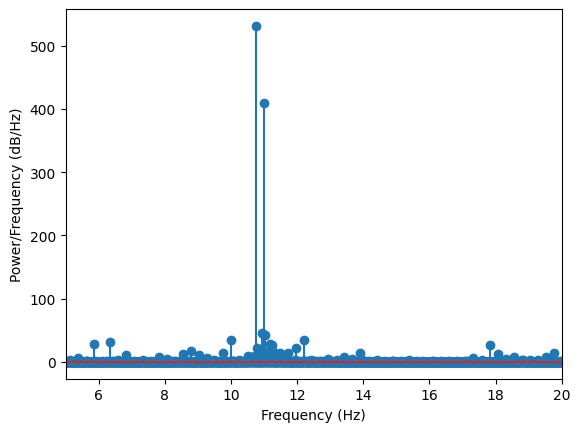

In [27]:
Fs = 250  # sampling frequency
f, pxx = periodogram(data, Fs)  # PSD estimate
plt.stem(f, pxx)  # plot in dB
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim(5, 20)
